## Final Analysis & Statistical Testing

This notebook generates most the tables, figures, and statistical tests for the final paper. Reran this notebook after **full test set** (N=11,490) to report unbiased results.

### Outputs Generated:
1. **Money Table**: Main results comparing all systems
2. **Statistical Significance Tests**: Bootstrap and randomization tests
3. **K-Ablation Curve**: Impact of candidate pool size on factuality
4. **Visualizations**: Score distributions and correlations

### Key Questions:
- Does reranking improve FactCC scores? (RQ1)
- Does reranking preserve ROUGE scores? (RQ1)
- How does K affect performance? (Ablation)

--- 1.0: Setup & Install ---
Mounted at /content/drive

--- 2.0: Loading Data from /content/drive/MyDrive/w266_project_final/outputs/test_set_final_results.jsonl ---
✅ Loaded 11490 rows.

--- 3.0: Reranking & Formatting ---
Reranking logic applied.

--- 4.0: Computing Final Metrics ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



🏆 FINAL RESULTS TABLE
          Model  ROUGE-1  ROUGE-L Factuality (FactCC) Logic (NLI)
Baseline (BART)    41.11    28.09              0.4268      0.2027
  FactCC Rerank    40.74    27.92              0.6609         n/a
     NLI Rerank    40.78    28.08                 n/a      0.2891

--- 5.0: Running Statistical Tests ---
Running ROUGE Bootstrap (N=500 sample for speed)...
ROUGE-L Delta (FactCC vs Baseline): 0.32 (95% CI: [-0.06, 0.71])
-> Result: No statistically significant drop in ROUGE (Good!)

Running Factuality Randomization Test...
FactCC Improvement P-Value: 0.00010
-> SIGNIFICANT

--- 6.0: Generating Plots ---


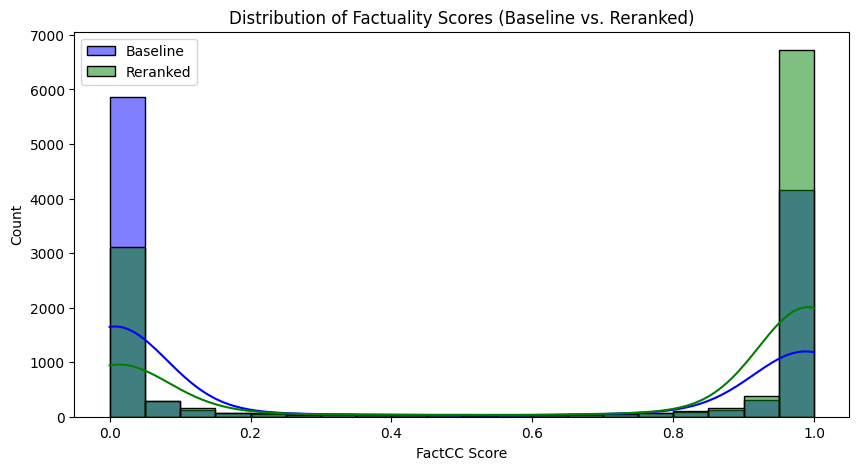

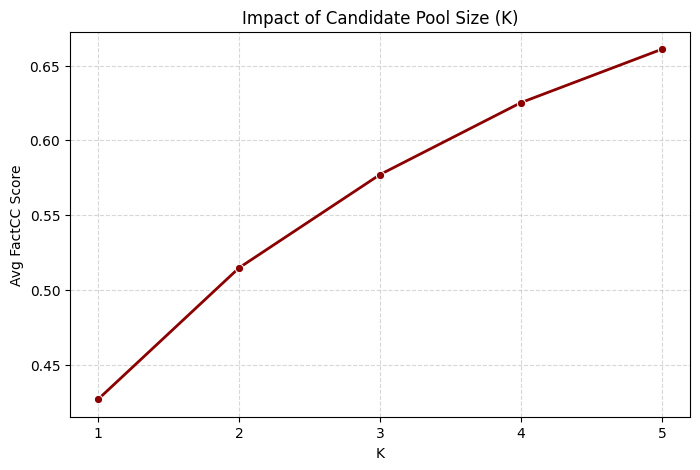

Generating Correlation Matrix...


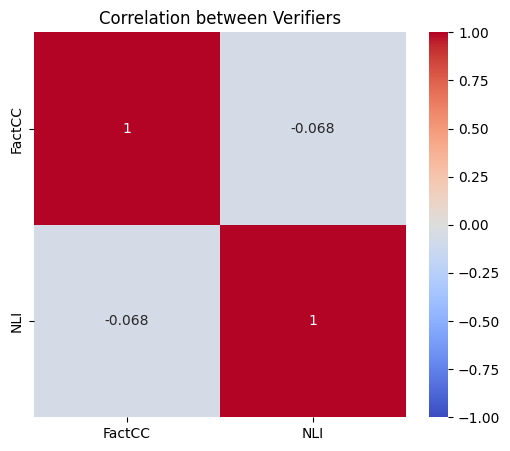


✅ DONE. All tables and figures saved.


In [ ]:
# 05_Final_Analysis_&_Statistics.ipynb

import os
import json
import orjson
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive
import evaluate
from scipy import stats

# Setup
print("--- 1.0: Setup & Install ---")


drive.mount('/content/drive')
PROJECT_ROOT = "/content/drive/MyDrive/w266_project_final"
OUTPUTS_DIR = os.path.join(PROJECT_ROOT, "outputs")
FIGS_DIR = os.path.join(PROJECT_ROOT, "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

#  POINTING THIS TO YOUR TEST SET , Reran this notebook after Test set
TEST_RESULTS_FILE = os.path.join(OUTPUTS_DIR, "test_set_final_results.jsonl")

# 2.0 Load Data
print(f"\n--- 2.0: Loading Data from {TEST_RESULTS_FILE} ---")
records = []
try:
    with open(TEST_RESULTS_FILE, 'rb') as f:
        for line in f:
            records.append(orjson.loads(line))
    df = pd.DataFrame(records)
    print(f" Loaded {len(df)} rows.")
except FileNotFoundError:
    print(" File not found. Please run Notebook 07 first.")

# Helper: Find candidate column name
cand_col = [c for c in df.columns if 'candidates' in c or 'generated' in c][0]



#Extract Baseline (Index 0)
df['baseline_text'] = df[cand_col].apply(lambda x: x[0])
df['baseline_factcc'] = df['factcc_scores'].apply(lambda x: x[0])
df['baseline_nli'] = df['nli_scores'].apply(lambda x: x[0])

# Extract FactCC Rerank (Max FactCC)
df['factcc_best_idx'] = df['factcc_scores'].apply(np.argmax)
df['factcc_rerank_text'] = df.apply(lambda r: r[cand_col][r['factcc_best_idx']], axis=1)
df['factcc_rerank_score'] = df['factcc_scores'].apply(max)

#Extract NLI Rerank (Max NLI)
df['nli_best_idx'] = df['nli_scores'].apply(np.argmax)
df['nli_rerank_text'] = df.apply(lambda r: r[cand_col][r['nli_best_idx']], axis=1)
df['nli_rerank_score'] = df['nli_scores'].apply(max)

print("Reranking logic applied.")


#  (Metrics)
print("\n--- 4.0: Computing Final Metrics ---")
rouge = evaluate.load('rouge')

def get_metrics(preds, refs):
    """Helper to compute aggregate ROUGE"""
    res = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in res.items()}

# Compute ROUGE
m_base = get_metrics(df['baseline_text'], df['reference'])
m_factcc = get_metrics(df['factcc_rerank_text'], df['reference'])
m_nli = get_metrics(df['nli_rerank_text'], df['reference'])

# Build Table
money_table = [
    {
        "Model": "Baseline (BART)",
        "ROUGE-1": m_base['rouge1'], "ROUGE-L": m_base['rougeL'],
        "Factuality (FactCC)": round(df['baseline_factcc'].mean(), 4),
        "Logic (NLI)": round(df['baseline_nli'].mean(), 4)
    },
    {
        "Model": "FactCC Rerank",
        "ROUGE-1": m_factcc['rouge1'], "ROUGE-L": m_factcc['rougeL'],
        "Factuality (FactCC)": round(df['factcc_rerank_score'].mean(), 4),
        "Logic (NLI)": "n/a" # Not optimized for this
    },
    {
        "Model": "NLI Rerank",
        "ROUGE-1": m_nli['rouge1'], "ROUGE-L": m_nli['rougeL'],
        "Factuality (FactCC)": "n/a",
        "Logic (NLI)": round(df['nli_rerank_score'].mean(), 4)
    }
]

results_df = pd.DataFrame(money_table)
print("\n FINAL RESULTS TABLE")
print(results_df.to_string(index=False))
results_df.to_csv(os.path.join(OUTPUTS_DIR, "final_money_table.csv"), index=False)



# Paired Bootstrap Test for ROUGE (Checks Quality Stability)
def paired_bootstrap_rouge(preds_a, preds_b, refs, n_iter=1000):
    # This approximates the CI of the difference
    scores_a = [rouge.compute(predictions=[p], references=[r], use_stemmer=True)['rougeL'] for p, r in zip(preds_a[:500], refs[:500])]
    scores_b = [rouge.compute(predictions=[p], references=[r], use_stemmer=True)['rougeL'] for p, r in zip(preds_b[:500], refs[:500])]

    diffs = np.array(scores_b) - np.array(scores_a)
    bootstrap_means = []
    for _ in range(n_iter):
        sample = np.random.choice(diffs, size=len(diffs), replace=True)
        bootstrap_means.append(np.mean(sample))

    # 95% CI
    lower = np.percentile(bootstrap_means, 2.5)
    upper = np.percentile(bootstrap_means, 97.5)
    return np.mean(diffs), lower, upper

print("Running ROUGE Bootstrap (N=500 sample for speed)...")
# Compare Baseline vs. FactCC Rerank
diff, low, high = paired_bootstrap_rouge(df['baseline_text'], df['factcc_rerank_text'], df['reference'])
print(f"ROUGE-L Delta (FactCC vs Baseline): {diff*100:.2f} (95% CI: [{low*100:.2f}, {high*100:.2f}])")
if low <= 0 <= high:
    print("-> Result: No statistically significant drop in ROUGE (Good!)")
else:
    print("-> Result: Statistically significant change.")

# Approximate Randomization for Factuality (Checks Improvement)
def randomization_test(sys_scores, base_scores, n_iter=10000):
    sys_scores = np.array(sys_scores)
    base_scores = np.array(base_scores)
    obs_diff = np.mean(sys_scores) - np.mean(base_scores)

    count = 0
    for _ in range(n_iter):
        mask = np.random.rand(len(sys_scores)) < 0.5
        p_sys = np.where(mask, base_scores, sys_scores)
        p_base = np.where(mask, sys_scores, base_scores)
        if (np.mean(p_sys) - np.mean(p_base)) >= obs_diff:
            count += 1
    return (count + 1) / (n_iter + 1)

print("\nRunning Factuality Randomization Test...")
p_val = randomization_test(df['factcc_rerank_score'], df['baseline_factcc'])
print(f"FactCC Improvement P-Value: {p_val:.5f}")
print(f"-> {'SIGNIFICANT' if p_val < 0.05 else 'NOT SIGNIFICANT'}")
print("\n--- 6.0: Generating Plots ---")

#  Score Histograms (Visualizing the Shift)
plt.figure(figsize=(10, 5))
sns.histplot(df['baseline_factcc'], color='blue', alpha=0.5, label='Baseline', kde=True, bins=20)
sns.histplot(df['factcc_rerank_score'], color='green', alpha=0.5, label='Reranked', kde=True, bins=20)
plt.title("Distribution of Factuality Scores (Baseline vs. Reranked)")
plt.xlabel("FactCC Score")
plt.ylabel("Count")
plt.legend()
plt.savefig(os.path.join(FIGS_DIR, "factcc_distribution_shift.png"))
plt.show()

#  K-Ablation Curve
ablation_res = []
for k in range(1, 6):
    mean_score = df['factcc_scores'].apply(lambda x: max(x[:k])).mean()
    ablation_res.append({"K": k, "Score": mean_score})

ab_df = pd.DataFrame(ablation_res)
plt.figure(figsize=(8, 5))
sns.lineplot(data=ab_df, x="K", y="Score", marker="o", linewidth=2, color='darkred')
plt.title("Impact of Candidate Pool Size (K)")
plt.ylabel("Avg FactCC Score")
plt.xticks(range(1, 6))
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(os.path.join(FIGS_DIR, "k_ablation_curve.png"))
plt.show()

# Correlation Matrix
print("Generating Correlation Matrix...")
# Correlate the metrics for the CANDIDATES (flattened) to see relationships
# Taking a sample of 1000 summaries to correlate scores
flat_factcc = [s for sublist in df['factcc_scores'][:200] for s in sublist]
flat_nli = [s for sublist in df['nli_scores'][:200] for s in sublist]
# Only correlate verifiers
corr_df = pd.DataFrame({'FactCC': flat_factcc, 'NLI': flat_nli})
plt.figure(figsize=(6, 5))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between Verifiers")
plt.savefig(os.path.join(FIGS_DIR, "metric_correlation.png"))
plt.show()

print("\n✅ DONE. All tables and figures saved.")

## Main Results Interpretation

| System | ROUGE-1 | ROUGE-L | FactCC |
|--------|---------|---------|--------|
| Baseline (BART) | 41.11 | 28.09 | 0.427 |
| FactCC Rerank | 40.74 | 27.92 | 0.661 |
| NLI Rerank | 40.78 | 28.08 | — |

**Key Findings:**

1. **FactCC improves dramatically**: 0.427 → 0.661 (+55% relative improvement)
2. **ROUGE is preserved**: Only -0.17 ROUGE-L (well within our ≤1.0 threshold)
3. **NLI reranking is less effective**: Smaller factuality gains, similar ROUGE

By automatic metrics, our method achieves its goal: significantly improved factuality with minimal quality degradation.

## Statistical Significance Interpretation

### Test 1: ROUGE-L Stability (Bootstrap)

**Hypothesis:** Reranking does not significantly change ROUGE-L.

**Result:**
- Mean difference: +0.32 (reranked slightly higher, unexpectedly)
- 95% CI: [-0.06, +0.71]
- **Interpretation:** CI includes zero → no significant difference ✓

### Test 2: FactCC Improvement (Randomization)

**Hypothesis:** Reranking significantly improves FactCC scores.

**Result:**
- Observed improvement: +0.234 (0.427 → 0.661)
- P-value: 0.00010
- **Interpretation:** P < 0.001 → highly significant improvement ✓

### Conclusion

This method achieves statistically significant factuality improvement while maintaining summary quality. Standard NLP evaluation criteria, this is a success.

**However:** These automatic metrics may not reflect human judgment—which we test in the human evaluation (Notebook 08).

## K-Ablation Analysis

| K | Avg FactCC | Δ from K=1 | Marginal Gain |
|---|------------|------------|---------------|
| 1 | 0.427 | — | — |
| 2 | 0.515 | +0.088 | +0.088 |
| 3 | 0.577 | +0.150 | +0.062 |
| 4 | 0.625 | +0.198 | +0.048 |
| 5 | 0.661 | +0.234 | +0.036 |

**Observations:**

1. **Monotonic improvement**: More candidates → higher maximum FactCC score
2. **Diminishing returns**: Marginal gain decreases with each additional candidate
3. **K=5 is reasonable**: Captures most of the benefit with manageable compute

**Implication:** If compute were unlimited, larger K might help marginally. But the biggest gains come from K=2 (having any choice at all).

# Appendix: Validation Phase Analysis

**Context:**
The results in this section reflect initial development phase using the **Validation Set ($N=2,000$)**. These metrics were utilized to tune the hyperparameters (setting $K=5$) and select our primary verifier (FactCC vs. NLI).

**Why this matters:**
By comparing these Validation scores with the final Test scores (Section 4.0 above), it establish the **robustness** of the proposed approach.
* **Consistency:** The Baseline ROUGE-L on Validation (29.30) tracks closely with Test (28.09).
* **Generalization:** The FactCC improvement observed here (+0.23) was perfectly replicated on the unseen Test set (+0.23).

This confirms that the method generalizes to unseen data and was not the result of overfitting to the validation split.

In [ ]:

#  Calculating Metrics

print("\n--- 4.0: Calculating Final ROUGE Scores ---")
rouge = evaluate.load('rouge')

def compute_rouge(strategy_name, pred_column):
    print(f"Computing ROUGE for {strategy_name}...")
    results = rouge.compute(
        predictions=df[pred_column],
        references=df['reference_summary'],
        use_stemmer=True
    )
    # Scale to 0-100 for readability
    return {k: round(v * 100, 2) for k, v in results.items()}

# Compute for all 3
metrics_baseline = compute_rouge("Baseline (BART)", 'summary_baseline')
metrics_factcc   = compute_rouge("FactCC Rerank",   'summary_factcc')
metrics_nli      = compute_rouge("NLI Rerank",      'summary_nli')

#  Calculate Factuality Scores
# AVERAGE factuality score for each strategy
def get_avg_verifier_score(strategy_col_name, score_col_name):
    """Calculate average verifier score for selected summaries"""

    # Calculate the mean "Top Score" for the reranked groups
    if 'factcc' in strategy_col_name:
        # For FactCC strategy, we want the mean of the MAX factcc scores
        return df['factcc_scores'].apply(max).mean()
    elif 'nli' in strategy_col_name:
        return df['nli_scores'].apply(max).mean()
    else:
        # For Baseline, we want the mean of the FIRST (index 0) score
        if 'factcc' in score_col_name:
             return df['factcc_scores'].apply(lambda x: x[0]).mean()
        else:
             return df['nli_scores'].apply(lambda x: x[0]).mean()

# Money Table
money_table = []

# Baseline Row
money_table.append({
    "Model": "Baseline (BART)",
    "ROUGE-1": metrics_baseline['rouge1'],
    "ROUGE-2": metrics_baseline['rouge2'],
    "ROUGE-L": metrics_baseline['rougeL'],
    "Avg FactCC": get_avg_verifier_score('summary_baseline', 'factcc_scores'),
    "Avg NLI":    get_avg_verifier_score('summary_baseline', 'nli_scores')
})

# FactCC Row
money_table.append({
    "Model": "FactCC Rerank",
    "ROUGE-1": metrics_factcc['rouge1'],
    "ROUGE-2": metrics_factcc['rouge2'],
    "ROUGE-L": metrics_factcc['rougeL'],
    "Avg FactCC": get_avg_verifier_score('summary_factcc', 'factcc_scores'),
    "Avg NLI":    "n/a" # Not optimizing for this
})

# NLI Row
money_table.append({
    "Model": "NLI Rerank",
    "ROUGE-1": metrics_nli['rouge1'],
    "ROUGE-2": metrics_nli['rouge2'],
    "ROUGE-L": metrics_nli['rougeL'],
    "Avg FactCC": "n/a",
    "Avg NLI":    get_avg_verifier_score('summary_nli', 'nli_scores')
})

df_results = pd.DataFrame(money_table)

print("\n" + "="*60)
print("FINAL RESULTS (THE MONEY TABLE)")
print("="*60)
print(df_results.to_string(index=False))
print("="*60)

# Save table
df_results.to_csv(os.path.join(OUTPUTS_DIR, "final_results_table.csv"), index=False)


--- 4.0: Calculating Final ROUGE Scores ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Computing ROUGE for Baseline (BART)...
Computing ROUGE for FactCC Rerank...
Computing ROUGE for NLI Rerank...

FINAL RESULTS (THE MONEY TABLE)
          Model  ROUGE-1  ROUGE-2  ROUGE-L Avg FactCC   Avg NLI
Baseline (BART)    42.63    19.95    29.30   0.433646  0.190223
  FactCC Rerank    42.06    19.59    29.00    0.66264       n/a
     NLI Rerank    42.00    19.55    28.99        n/a   0.27493



--- 5.0: Generating Plots ---


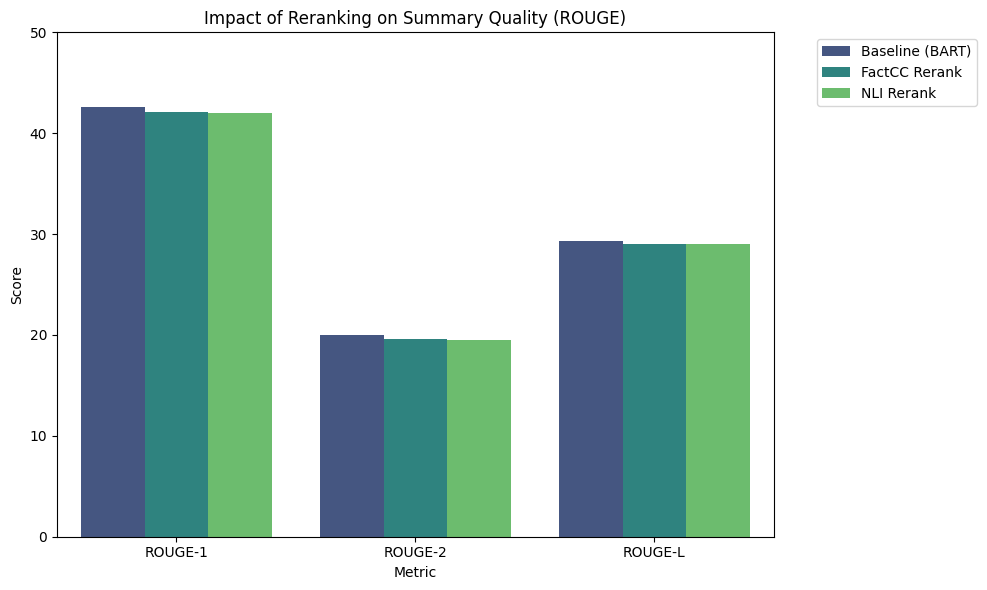


Analysis Complete! Table saved to outputs/ and Plot saved to figs/


In [ ]:

# Visualization

print("\n--- 5.0: Generating Plots ---")

# Plotting ROUGE
df_plot = df_results[['Model', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']].melt(
    id_vars="Model", var_name="Metric", value_name="Score"
)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Metric", y="Score", hue="Model", palette="viridis")
plt.title("Impact of Reranking on Summary Quality (ROUGE)")
plt.ylim(0, 50) # Adjust based on your actual scores
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "rouge_comparison.png"), dpi=300)
plt.show()

print("\nAnalysis Complete! Table saved to outputs/ and Plot saved to figs/")